In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split

In [3]:
# For imputing missing values for level_binary
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
# Libraries for predicting
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [5]:
# For imputation
from sklearn.ensemble import RandomForestClassifier
from statistics import mode

In [6]:
# Libraries for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
# Libraries for feature selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC, LinearSVR

In [8]:
#To save the final model
import pickle

In [9]:
from task2 import process_data

In [10]:
#Load data
reg_data = pd.read_csv("../results/processed_data/forecasting_processed.csv")

In [11]:
reg_data.head()

,time_stamp,y,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level
0,2004-03-10T12:30:00Z,1185,2.6,150.0,11.9,NaN,166.0,1056.0,113.0,1692.0,NaN,13.6,48.9,0.7578,High
1,2004-03-10T13:30:00Z,1136,2.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,High
2,2004-03-10T14:30:00Z,1094,2.2,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,NaN,0.7502,NaN
3,2004-03-10T15:30:00Z,1010,2.2,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,High
4,2004-03-10T16:30:00Z,1011,1.6,51.0,6.5,836.0,131.0,1205.0,116.0,NaN,1110.0,NaN,59.6,0.7888,High


In [12]:
X = process_data(reg_data)

==== Processing co_gt ====
 	 Imputing 

==== Processing nhmc ====
 	 Imputing 

==== Processing c6h6 ====
 	 Imputing 

==== Processing s2 ====
 	 Imputing 

==== Processing nox ====
 	 Imputing 

==== Processing s3 ====
 	 Imputing 

==== Processing no2 ====
 	 Imputing 

==== Processing s4 ====
 	 Imputing 

==== Processing s5 ====
 	 Imputing 

==== Processing t ====
 	 Imputing 

==== Processing rh ====
 	 Imputing 

==== Processing ah ====
 	 Imputing 

==== Processing level ====
 	 Imputing 



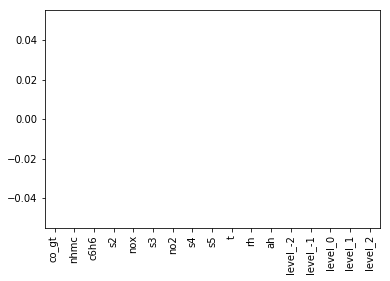

In [13]:
X.isnull().sum().plot(kind='bar')

In [14]:
X.head()

,co_gt,nhmc,c6h6,s2,nox,s3,no2,s4,s5,t,rh,ah,level_-2,level_-1,level_0,level_1,level_2
0,2.6,150.0,11.9,972.775376,166.0,1056.0,113.0,1692.000000,1038.103476,13.600000,48.900000,0.7578,0,0,0,1,0
1,2.0,112.0,9.4,955.000000,103.0,1174.0,92.0,1559.000000,972.000000,13.300000,47.700000,0.7255,0,0,0,1,0
2,2.2,88.0,9.0,939.000000,131.0,1140.0,114.0,1555.000000,1074.000000,11.900000,34.923929,0.7502,0,0,0,1,0
3,2.2,80.0,9.2,948.000000,172.0,1092.0,122.0,1584.000000,1203.000000,11.000000,60.000000,0.7867,0,0,0,1,0
4,1.6,51.0,6.5,836.000000,131.0,1205.0,116.0,1452.859605,1110.000000,9.803333,59.600000,0.7888,0,0,0,1,0


In [15]:
y = reg_data['y']

In [16]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=7)

In [17]:
def fit_evaluate(model): 
    '''
    Function prints the training and validation scores.
    Args
        Model: Sklearn object with predict method.
    
    Returns
        None
    '''
    model.fit(X_train, y_train)
    train_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_train),y_true=y_train))
    val_rmse = np.sqrt(mean_squared_error(y_pred=model.predict(X_val),y_true=y_val))
    print("Train RMSE: ", train_rmse)
    print("Validation RMSE: ", val_rmse)

## RandomForestRegressor

In [18]:
rf_reg_opt = RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250)
fit_evaluate(rf_reg_opt)

Train RMSE:  92.1062488331
Validation RMSE:  234.425391942


## Test RMSE with the best model

In [19]:
test_rmse = np.sqrt(mean_squared_error(y_pred=rf_reg_opt.predict(X_test),y_true=y_test))
print("Test RMSE: ", test_rmse)

Test RMSE:  226.619120599


# Retraining on the entire data

In [20]:
rf_opt = RandomForestRegressor(max_depth = None, max_features = 'sqrt', n_estimators = 250)
rf_opt.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
rmse = np.sqrt(mean_squared_error(y_pred=rf_opt.predict(X),y_true=y))
print("RMSE: ", rmse)

RMSE:  91.3470126353


## Saving final model

In [22]:
with open('../results/pickles/task2_model.pickle', 'wb') as save_model:
    pickle.dump(rf_opt, save_model)